# Template for Gaussian NaiveBayes Comparison

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.model_selection import cross_validate, KFold

In [3]:
np.random.seed(0)

## Assessment of the Gaussian Naive Bayes Classifier

In [4]:
def classifier_assessment(X, y, priors=None):
    """
    GaussianNB comparison for the different datasets

    args: X dataset of features
          y target set of values for classification

    returns: 
        - a dummy classifier score using "most frequent" value assignment
        - the mean of the Gaussian NaiveBayes Claffifier prediction scores taken from a 
          5 fold cross validation on the dataset
    """
    
    clf_nb = GaussianNB(priors=priors)
    
    print(f"Using prior probability: {priors}")
    
    def performance_graphics(X=X, y=y, clf=clf_nb):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        clf.fit(X_train, y_train)
     
        proba_ = clf.predict_proba(X_test)[:, 1]

        precision, recall, thresholds = precision_recall_curve(y_test, proba_)
        fp, tp, thresholds_roc = roc_curve(y_test, proba_)
        
        auc_score = np.round(roc_auc_score(y_test, proba_), 4)

        close_default = np.argmin(np.abs(thresholds - 0.5))
        close_zero = np.argmin(np.abs(thresholds_roc))

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))

        ax1.plot(precision, recall, label="Precision Recall Curve")
        ax1.plot(precision[close_default], 
                 recall[close_default], 'o', 
                 c='r', markersize=10, 
                 label='threshold 0.5', 
                 fillstyle="none", mew=2)
        ax1.set_title("RF performance")
        ax1.set_xlabel("Precision")
        ax1.set_ylabel("Recall")
        ax1.legend(loc='best')

        ax2.plot(fp, tp, label="ROC curve")
        ax2.plot(fp[close_zero], 
                 tp[close_zero], 'o', 
                 c='r', markersize=10, 
                 label='threshold 0', 
                 fillstyle="none", mew=2)
        ax2.set_title(f"ROC performance: AUC Score {auc_score}")
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive (Recall)")
        ax2.legend(loc='best')

        plt.show();

    kfold = KFold(n_splits=5)
    cross_val = cross_validate(clf_nb, X, y, cv=kfold, return_estimator=True)
    mean_score = cross_val['test_score'].mean()
        
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X,y)
    d_score = dummy_clf.score(X,y)
    
    graphic = performance_graphics

    return d_score, mean_score, graphic

# Compare Datasets

Leave commented until all values are in scope, then uncomment and compare. 

In [47]:
# # # # # # # # # The results of the combinations: 

obj_ = [('testing dataset', dummy_single,  single_score, (83, 2)), 
       ('testing and acs datasets', dummy_double, score_two_datasets, (83, 119)),\
       ('testing, acs, and county survey',dummy_tripple, three_ds_score, (83, 210)), \
       ('plus voters', dummy_four, four_ds_score, (83, 211)), \
       ('plus voters, prior probability', dummy_four_p, four_ds_score_p, (83, 211))]

condition = [c[0] for c in obj_]
dummy_results = [d[1] for d in obj_]
results = [r[2] for r in obj_]
shape = [s[3] for s in obj_]

pd.DataFrame({'dummy classifier': dummy_results, 'cross val score': results, 'data set shape': shape}, index=condition)

,dummy classifier,cross val score,data set shape
testing dataset,0.73494,0.891176,"(83, 2)"
testing and acs datasets,0.73494,0.891176,"(83, 119)"
"testing, acs, and county survey",0.73494,0.891176,"(83, 210)"
plus voters,0.73494,0.891176,"(83, 211)"
"plus voters, prior probability",0.73494,0.891176,"(83, 211)"


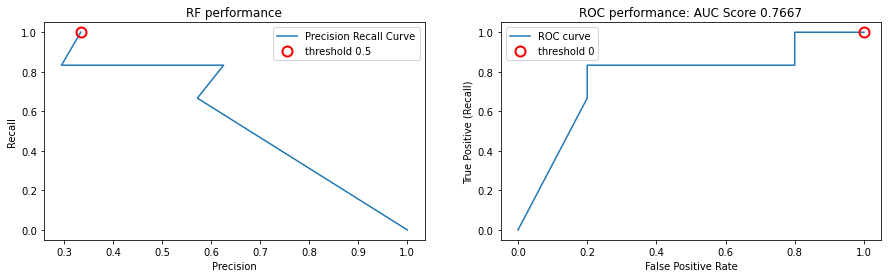

In [49]:
# graphic_single()
# graphic_two()
# graphic_three()
# graphic_four()
# graphic_four_p()

## Initial testing dataset of blood lead levels

In [7]:
# dataset prepared with this notebook: 
# https://github.com/Cameron-Grams/ComparisonCollection/blob/main/ebll_exploration.ipynb

df_ebll = pd.read_csv('./data/ebll_classifier_2014.csv')

In [8]:
# standardize the county names

df_ebll = df_ebll.iloc[:83, :]
df_ebll['county'] = df_ebll['County Name'].apply(lambda x: x.split()[:-1])
df_ebll['county'] = df_ebll['county'].apply(lambda x: (' ').join(x).lower())
# df_ebll.tail(30)

In [9]:
df_ebll = df_ebll.set_index('county')
df_ebll = df_ebll.iloc[:, 2:]
starting_df = df_ebll.iloc[:, :-1]
starting_df = starting_df.reset_index()
target = df_ebll.iloc[:, -1]

### Prior knowledge of Blood Lead Levels 2014

In [10]:
low = sum(target == 0)
high = sum(target == 1)
low, high

(61, 22)

In [11]:
prior_prob = [(low/83), (high/83)]
prior_prob

[0.7349397590361446, 0.26506024096385544]

### Assess single dataset

In [12]:
df_single_set = starting_df.set_index('county')
X = df_single_set
y = target
X.shape

(83, 2)

In [13]:
dummy_single, single_score, graphic_single = classifier_assessment(X, y)
dummy_single, single_score

Using prior probability: None


(0.7349397590361446, 0.8911764705882353)

In [14]:
# graphic_single()

## Add American Community Survey dataset

In [15]:
# dataset prepared with this notebook:
# https://github.com/Cameron-Grams/ComparisonCollection/blob/main/acs_2014.ipynb

df_acs = pd.read_csv('./data/cleaned_2014_acs.csv')

In [16]:
# df_acs.head()

In [17]:
# format county names
county = df_acs['County Name'].apply(lambda x: x.split()[:-1])
county = [(' ').join(x).lower() for x in county][:-1]

In [18]:
# need to replace the strings with integers
# get columns needed for conversion 
cols = df_acs.columns[1:]
df_acs_1 = df_acs.iloc[:, 1:]

In [19]:
# df contains a mixed collection of strings and numbers 
string_values = df_acs_1.values

In [20]:
new_vals = []
for arr in string_values:
    arr_2 = [x if (type(x) == int or type(x) == float) else int(x.replace(',', '')) for x in arr]
    new_vals.append(arr_2)

In [21]:
# last sample is the summary for Michigan as a state
number_array = np.array(new_vals)[:-1]

In [22]:
df_acs_2 = pd.DataFrame(number_array, columns=cols)

In [23]:
df_acs_2['county'] = county
df_acs_2.head()

,Population 16 years and over,In labor force,Civilian labor force,Employed,Unemployed,Armed Forces,Not in labor force,Civilian labor force.1,Females 16 years and over,In labor force.1,...,With health insurance coverage.2,With private health insurance.2,With public coverage.2,No health insurance coverage.3,Not in labor force:,With health insurance coverage.3,With private health insurance.3,With public coverage.3,No health insurance coverage.4,county
0,9424.0,3796.0,3796.0,3294.0,502.0,0.0,5628.0,3796.0,4668.0,1830.0,...,290.0,177.0,128.0,188.0,2168.0,1849.0,1168.0,988.0,319.0,alcona
1,8221.0,3602.0,3602.0,3175.0,427.0,0.0,4619.0,3602.0,3618.0,1720.0,...,226.0,110.0,118.0,168.0,1589.0,1364.0,992.0,548.0,225.0,alger
2,87238.0,54617.0,54614.0,50406.0,4208.0,3.0,32621.0,54614.0,44131.0,25248.0,...,2105.0,1432.0,761.0,1763.0,15925.0,13143.0,8706.0,5896.0,2782.0,allegan
3,24077.0,13731.0,13659.0,12227.0,1432.0,72.0,10346.0,13659.0,12369.0,6583.0,...,736.0,351.0,425.0,597.0,4421.0,3890.0,2051.0,2344.0,531.0,alpena
4,19340.0,10762.0,10759.0,9462.0,1297.0,3.0,8578.0,10759.0,9760.0,5076.0,...,583.0,388.0,208.0,565.0,3190.0,2716.0,1886.0,1103.0,474.0,antrim


In [24]:
df_two_datasets_ = pd.merge(starting_df, df_acs_2, on='county')
df_two_datasets = df_two_datasets_.set_index('county')
df_two_datasets.shape

(83, 119)

In [25]:
X = df_two_datasets
y = target

In [26]:
dummy_double, score_two_datasets, graphic_two = classifier_assessment(X, y)
dummy_double, score_two_datasets

Using prior probability: None


(0.7349397590361446, 0.8911764705882353)

In [27]:
# graphic_two()

## Add county demographic information

In [28]:
df_demog = pd.read_csv('./data/county_ages_2014.csv')
# df_demog.head(3)

In [29]:
df_demog['county'] = df_demog['CTYNAME'].apply(lambda x: x.split()[:-1])
df_demog['county'] = df_demog['county'].apply(lambda x: (' ').join(x).lower())

In [30]:
df_demog = df_demog.iloc[:, 6:]
# df_demog.head()

In [31]:
df_three = pd.merge(df_two_datasets_, df_demog, on='county')
df_three.shape

(83, 210)

## Full feature classification

In [32]:
df_ = df_three.set_index('county')
X = df_
y = y

In [33]:
dummy_tripple, three_ds_score, graphic_three = classifier_assessment(X, y)
dummy_tripple, three_ds_score

Using prior probability: None


(0.7349397590361446, 0.8911764705882353)

## Voters

In [34]:
df_vote = pd.read_csv('./data/VoterCount.txt', sep=' ', names=['county_', 'voters'])

In [35]:
with open('./data/VoterCount.txt', 'r') as file:
    lines = file.readlines()
    

In [36]:
counties = []
registered_voters = []

for line in lines:
    line_stats = re.findall('\S+', line)
    counties.append(line_stats[:-1])
    registered_voters.append(line_stats[-1])

In [37]:
# counties = ['St.' + ' ' + x[1] if x[0] == 'St' else x for x in counties]

In [38]:
counties = [(' ').join(x).lower() for x in counties]

In [39]:
# counties
registered_voters = [int(x) for x in registered_voters]
# registered_voters

In [40]:
df_v = pd.DataFrame({'county': counties, 'registered_voters': registered_voters})

In [41]:
df_v.iloc[76, 0] = 'st. clair'
df_v.iloc[77, 0] = 'st. joseph'

In [42]:
# df_v.tail(20)

In [43]:
df = pd.merge(df_three, df_v, on='county')
df.shape

(83, 211)

In [44]:
df = df.set_index('county')
X = df
y = y

In [45]:
dummy_four, four_ds_score, graphic_four = classifier_assessment(X, y)
dummy_four, four_ds_score

Using prior probability: None


(0.7349397590361446, 0.8911764705882353)

In [46]:
dummy_four_p, four_ds_score_p, graphic_four_p = classifier_assessment(X, y, prior_prob)
dummy_four_p, four_ds_score_p

Using prior probability: [0.7349397590361446, 0.26506024096385544]


(0.7349397590361446, 0.8911764705882353)